На основе подготовленной для нейросети таблицы данных с HeadHunter создайте 6 архитектур нейросетей, поэкспериментируйте с гиперпараметрами.
Используйте только числовые данные, текстовые не подавайте.

Результаты в конце проанализируйте.

Перед началом выполнения, пожалуйста, запустите раздел "Подготовка".

### Импорты

In [ ]:
# Работа с файловой системой
import os

# Регулярные выражения
import re

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Вывод информации в Jupyter Notebook
from IPython.display import display

# Метрики для расчета ошибок
from sklearn.metrics import mean_absolute_error

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Основные слои
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

%matplotlib inline

### Загрузка и считывание датасета

In [ ]:
# скачиваем базу
if not os.path.exists("hh_fixed.csv"):
    # Загрузка файла из облака
    gdown.download(
        "https://storage.yandexcloud.net/aiueducation/Content/base/l10/hh_fixed.csv",
        None,
        quiet=True,
    )

# Чтение файла базы данных
df = pd.read_csv("hh_fixed.csv", index_col=0)

# Вывод количества резюме и числа признаков
print(df.shape)

display(df.head(3))

(62967, 12)


,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано


### Вывод индексов столбцов в отдельные константы

In [ ]:
# Настройка номеров столбцов

COL_SEX_AGE = df.columns.get_loc("Пол, возраст")
COL_SALARY = df.columns.get_loc("ЗП")
COL_POS_SEEK = df.columns.get_loc("Ищет работу на должность:")
COL_POS_PREV = df.columns.get_loc("Последеняя/нынешняя должность")
COL_CITY = df.columns.get_loc("Город")
COL_EMPL = df.columns.get_loc("Занятость")
COL_SCHED = df.columns.get_loc("График")
COL_EXP = df.columns.get_loc("Опыт (двойное нажатие для полной версии)")
COL_EDU = df.columns.get_loc("Образование и ВУЗ")
COL_UPDATED = df.columns.get_loc("Обновление резюме")

### Функции подготовки данных

In [ ]:
# Замена концов строк на пробелы, удаление символа с кодом 0xA0
# обрезка краевых пробелов, приведение к нижнему регистру

def purify(x):
    if isinstance(x, str):  # Если значение - строка:
        x = x.replace("\n", " ").replace("\xa0", "").strip().lower()
    return x

In [ ]:
# Выделение подстроки вида ДД.ММ.ГГГГ и возвращение значения года
def extract_year(x):
    try:
        return int(
            re.search(r"\d\d.\d\d.(\d{4})", x)[1]
        )  # Ожидается строка вида 'dd.mm.yyyy ...'

    except (IndexError, TypeError, ValueError):
        return 0

In [ ]:
# Параметрические данные для функций разбора
# Курсы валют для зарплат
currency_rate = {
    "usd": 65.0,
    "kzt": 0.17,
    "грн": 2.6,
    "белруб": 30.5,
    "eur": 70.0,
    "kgs": 0.9,
    "сум": 0.007,
    "azn": 37.5,
}

# Списки и словари для разбиения на классы
# Для ускорения работы добавлен счетчик классов, который будет вычислен ниже

# Список порогов возраста
age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

# Список порогов опыта работы в месяцах
experience_class = [0, [7, 13, 25, 37, 61, 97, 121, 157, 193, 241]]

# Классы городов
city_class = [
    0,
    {
        "москва": 0,
        "санкт-петербург": 1,
        "новосибирск": 2,
        "екатеринбург": 2,
        "нижний новгород": 2,
        "казань": 2,
        "челябинск": 2,
        "омск": 2,
        "самара": 2,
        "ростов-на-дону": 2,
        "уфа": 2,
        "красноярск": 2,
        "пермь": 2,
        "воронеж": 2,
        "волгоград": 2,
        "прочие города": 3,
    },
]

# Классы занятости
employment_class = [
    0,
    {
        "стажировка": 0,
        "частичная занятость": 1,
        "проектная работа": 2,
        "полная занятость": 3,
    },
]

# Классы графика работы
schedule_class = [
    0,
    {"гибкий график": 0, "полный день": 1, "сменный график": 2, "удаленная работа": 3},
]

# Классы образования
education_class = [
    0,
    {
        "высшее образование": 0,
        "higher education": 0,
        "среднее специальное": 1,
        "неоконченное высшее": 2,
        "среднее образование": 3,
    },
]


In [ ]:
# Вычисление счетчиков для данных разбиения

for class_desc in [
    age_class,
    experience_class,
    city_class,
    employment_class,
    schedule_class,
    education_class,
]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [ ]:
# Получение one hot encoding представления значения класса

def int_to_ohe(arg, class_list):
    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i  # Интервал найден - назначение класса
            break
    else:  # Внимание: for/else
        cls = num_classes - 1  # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [ ]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.0

    return result

In [ ]:
# Разбор значений пола, возраста
base_update_year = 2025
def extract_sex_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    sex = 1.0 if "муж" in arg else 0.0

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r"\d{4}", arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return sex, years

In [ ]:
# Преобразование значения возраста в one hot encoding

def age_years_to_ohe(arg):
    return int_to_ohe(arg, age_class)

In [ ]:
# Преобразование данных об опыте работы в one hot encoding

def experience_months_to_ohe(arg):
    return int_to_ohe(arg, experience_class)

In [ ]:
# Разбор значения зарплаты

def extract_salary(arg):
    try:
        # Выделение числа и преобразование к float
        value = float(re.search(r"\d+", arg)[0])

        # Поиск символа валюты в строке, и, если найдено,
        # приведение к рублю по курсу валюты
        for currency, rate in currency_rate.items():
            if currency in arg:
                value *= rate
                break

    except TypeError:
        # Если не получилось выделить число - вернуть 0
        value = 0.0

    return value / 1000.0  # В тысячах рублей

In [ ]:
# Разбор данных о городe и преобразование в one hot encoding
def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка на слова
    split_array = re.split(r"[ ,.:()?!]", arg)

    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class[1].get(word, -1)
        if city_cls >= 0:
            break
    else:  # Внимание: for/else
        # Город не в city_class - значит его класс "прочие города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [ ]:
# Разбор данных о желаемой занятости и преобразование в multi
def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [ ]:
# Разбор данных о желаемом графике работы и преобразование в multi
def extract_schedule_to_multi(arg):
    return str_to_multi(arg, schedule_class)

In [ ]:
# Разбор данных об образовании и преобразование в multi
def extract_education_to_multi(arg):
    result = str_to_multi(arg, education_class)

    # Поправка: неоконченное высшее не может быть одновременно с высшим
    if result[2] > 0.0:
        result[0] = 0.0

    return result

In [ ]:
# Разбор данных об опыте работы - результат в месяцах
def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r"(\d+)\s+(год.?|лет)", arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество лет равно 0
        years = 0

    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r"(\d+)\s+месяц", arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months

### Функции подготовки выборок

In [ ]:
def extract_row_data(row):
    # Извлечение и преобразование данных
    sex, age = extract_sex_age_years(row[COL_SEX_AGE])  # Пол, возраст
    sex_vec = np.array([sex])  # Пол в виде вектора
    age_ohe = age_years_to_ohe(age)  # Возраст в one hot encoding
    city_ohe = extract_city_to_ohe(row[COL_CITY])  # Город
    empl_multi = extract_employment_to_multi(row[COL_EMPL])  # Тип занятости
    sсhed_multi = extract_schedule_to_multi(row[COL_SCHED])  # График работы
    edu_multi = extract_education_to_multi(row[COL_EDU])  # Образование
    exp_months = extract_experience_months(row[COL_EXP])  # Опыт работы в месяцах
    exp_ohe = experience_months_to_ohe(exp_months)  # Опыт работы в one hot encoding
    salary = extract_salary(row[COL_SALARY])  # Зарплата в тысячах рублей
    salary_vec = np.array([salary])  # Зарплата в виде вектора

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack(
        [sex_vec, age_ohe, city_ohe, empl_multi, sсhed_multi, edu_multi, exp_ohe]
    )

    # Возврат входных данных и выходных (зарплаты)
    return x_data, salary_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []

    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:  # Данные добавляются, только если есть зарплата
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [20]:
# Формирование выборки из загруженного набора данных
x_train_01, y_train = construct_train_data(df.values)

In [21]:
# Форма наборов параметров и зарплат
print(x_train_01.shape)
print(y_train.shape)

# Пример обработанных данных
n = 0
print(x_train_01[n])
print(y_train[n])

(62967, 39)
(62967, 1)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[40.]


### Функция отрисовки графика истории обучения

In [ ]:
def plot_history(history):
    plt.plot(
        history.history["mae"], label="Средняя абсолютная ошибка на обучающем наборе"
    )
    plt.plot(
        history.history["val_mae"],
        label="Средняя абсолютная ошибка на проверочном наборе",
    )
    plt.xlabel("Эпоха обучения")
    plt.ylabel("Средняя абсолютная ошибка")
    plt.legend()
    plt.show()

### Создание и обучение моделей

In [ ]:
# Ваше решение
def create_model(layers=3, neurons=256, use_dropout=False):
    model = Sequential() # Создание модели
    model.add(Input(shape=(x_train_01.shape[1],)))  # Входной слой
    model.add(BatchNormalization())

    units = neurons # Количество нейронов в первом слое
    for _ in range(layers):
        model.add(Dense(units, activation="relu"))
        if use_dropout: # Если используется дропаут
            model.add(Dropout(0.2))
        # Уменьшение количества нейронов в следующем слое вдвое
        units = max(8, units // 2) 

    model.add(Dense(1, activation="linear")) # Выходной слой
    # Компиляция модели с оптимизатором Adam и функцией потерь MSE
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="mse", metrics=["mae"])

    return model # Возврат созданной модели


# Функция для обучения модели и сохранения результатов в таблицу
def fit_model(models_table, layers=3, neurons=256, use_dropout=False):
    models_table["Количество слоев"].append(layers)
    models_table["Нейронов в первом слое"].append(neurons)
    models_table["Дропаут"].append("Да" if use_dropout else "Нет")

    model = create_model(layers, neurons, use_dropout) # Создание модели

    # Обучение модели
    history = model.fit(
        x_train_01,
        y_train,
        epochs=50,
        batch_size=256,
        validation_split=0.15,
        verbose=1,
    )

    pred = model.predict(x_train_01) # Предсказание на обучающей выборке
    error = mean_absolute_error(pred, y_train) # Расчет средней абсолютной ошибки

    models_table["Ошибка на обучающей выборке"].append(history.history["mae"][-1])
    models_table["Ошибка на проверочной выборке"].append(history.history["val_mae"][-1])
    models_table["Средняя абсолютная ошибка"].append(error)

    plot_history(history) # Отрисовка графиков обучения


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 10870.6670 - mae: 76.7671 - val_loss: 12149.9512 - val_mae: 81.0199
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11021.8633 - mae: 76.4688 - val_loss: 11936.4365 - val_mae: 79.7204
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10894.3203 - mae: 74.6840 - val_loss: 11624.1689 - val_mae: 77.8165
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10536.2451 - mae: 73.0035 - val_loss: 11187.3076 - val_mae: 75.1143
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9810.4463 - mae: 69.8143 - val_loss: 10604.7344 - val_mae: 71.4204
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9569.0332 - mae: 66.4171 - val_loss: 9902.2686 - val_mae: 66.8036
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8507.7109 - mae: 60.7195 - val_loss: 9104.5127 - val_mae: 61.3888
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7859.0913 - mae: 56.1269 - val_loss: 8250.9385 -

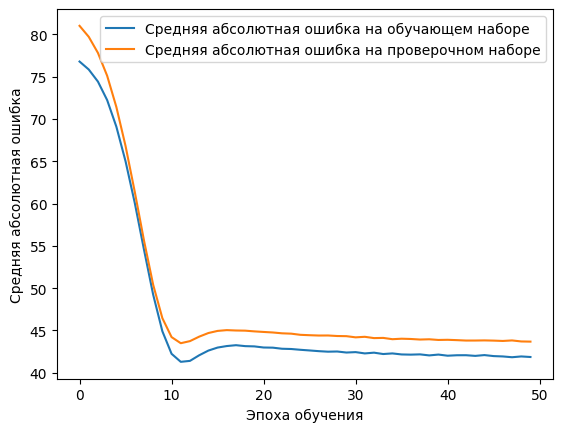

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 10756.1016 - mae: 76.4830 - val_loss: 11717.0430 - val_mae: 78.4240
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10708.8506 - mae: 70.3577 - val_loss: 9624.7373 - val_mae: 64.8204
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7652.1079 - mae: 55.0390 - val_loss: 6937.8320 - val_mae: 48.0056
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5992.8501 - mae: 43.2338 - val_loss: 5627.3013 - val_mae: 44.5637
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4948.7271 - mae: 43.0436 - val_loss: 5344.5312 - val_mae: 45.3729
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4916.0454 - mae: 43.8787 - val_loss: 5241.3325 - val_mae: 45.2893
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4676.7534 - mae: 43.3691 - val_loss: 5174.5059 - val_mae: 45.0995
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4771.2510 - mae: 43.4033 - val_loss: 5125.1724 - val_

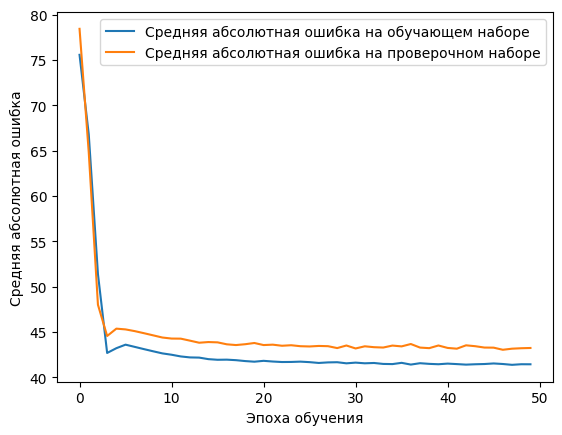

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 10967.3545 - mae: 77.0630 - val_loss: 12204.4814 - val_mae: 81.3598
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10908.4453 - mae: 76.4565 - val_loss: 12077.8174 - val_mae: 80.5714
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11255.6816 - mae: 75.8600 - val_loss: 11844.3301 - val_mae: 79.1354
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10753.2090 - mae: 74.6689 - val_loss: 11444.9404 - val_mae: 76.6726
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10906.5791 - mae: 71.8453 - val_loss: 10844.0293 - val_mae: 72.8766
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9399.4365 - mae: 67.0406 - val_loss: 10020.2764 - val_mae: 67.4675
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8659.5576 - mae: 61.5819 - val_loss: 8983.4014 - val_mae: 60.4395
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7458.4316 - mae: 54.0054 - val_loss: 7835.3794

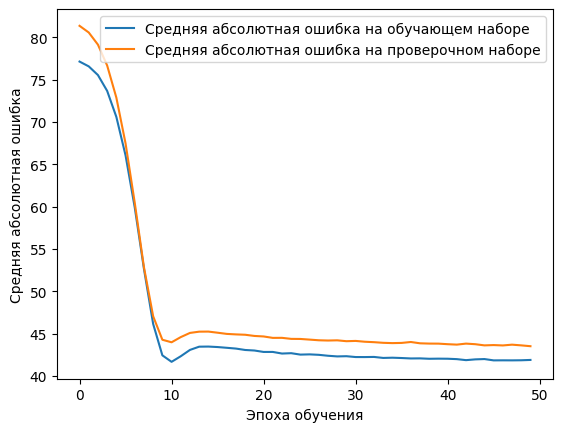

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 11875.9404 - mae: 77.4656 - val_loss: 12228.6475 - val_mae: 81.5130
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11086.1377 - mae: 76.8212 - val_loss: 12160.7236 - val_mae: 81.0920
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10993.5850 - mae: 76.7558 - val_loss: 12030.3125 - val_mae: 80.2961
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11050.3818 - mae: 75.7055 - val_loss: 11816.0781 - val_mae: 78.9992
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10792.0439 - mae: 74.6620 - val_loss: 11463.5527 - val_mae: 76.8698
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10072.1641 - mae: 72.1135 - val_loss: 10931.4766 - val_mae: 73.5876
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9441.5088 - mae: 68.5239 - val_loss: 10215.6436 - val_mae: 69.0022
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9268.7559 - mae: 63.9052 - val_loss: 9335.77

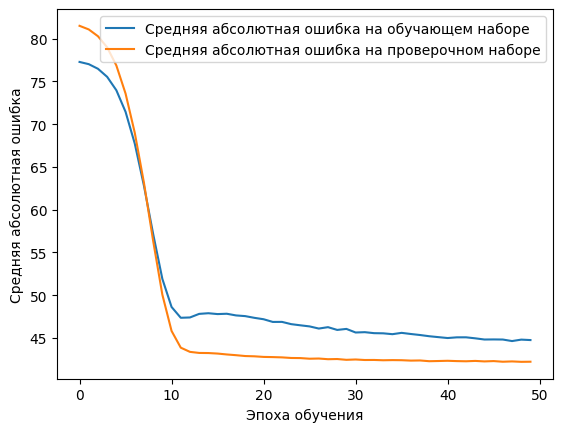

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 10903.9248 - mae: 76.8038 - val_loss: 11749.0752 - val_mae: 78.6007
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10212.2559 - mae: 69.3921 - val_loss: 8439.0684 - val_mae: 56.7680
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7244.7339 - mae: 47.7329 - val_loss: 5658.5464 - val_mae: 45.5726
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4799.6147 - mae: 44.2944 - val_loss: 5380.1987 - val_mae: 46.0470
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5168.1152 - mae: 44.2509 - val_loss: 5243.3828 - val_mae: 45.4390
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4973.5771 - mae: 43.2182 - val_loss: 5155.4927 - val_mae: 44.9042
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4381.6143 - mae: 42.8013 - val_loss: 5087.0723 - val_mae: 44.7943
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4784.3350 - mae: 42.9715 - val_loss: 5045.1641 - val_m

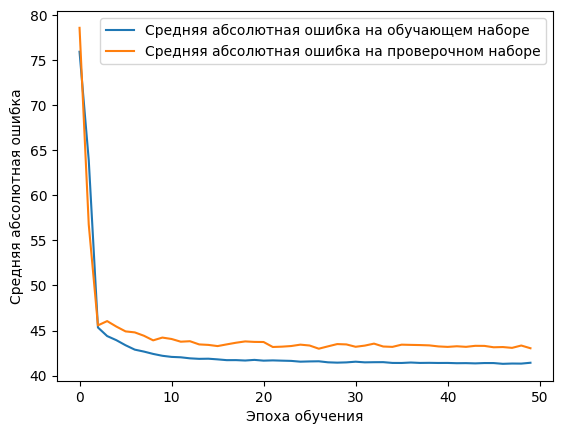

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 11138.5654 - mae: 76.9922 - val_loss: 11801.6777 - val_mae: 78.8995
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9663.0566 - mae: 69.5331 - val_loss: 8409.2666 - val_mae: 56.3975
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6685.8770 - mae: 47.7102 - val_loss: 5648.8037 - val_mae: 45.8072
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5302.2998 - mae: 45.4552 - val_loss: 5403.6709 - val_mae: 45.5265
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5067.8789 - mae: 44.8368 - val_loss: 5279.4248 - val_mae: 45.2486
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4916.1519 - mae: 44.0648 - val_loss: 5196.7817 - val_mae: 44.8939
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4743.9917 - mae: 43.1844 - val_loss: 5129.9355 - val_mae: 44.6522
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4652.8647 - mae: 43.2927 - val_loss: 5085.7466 - val_ma

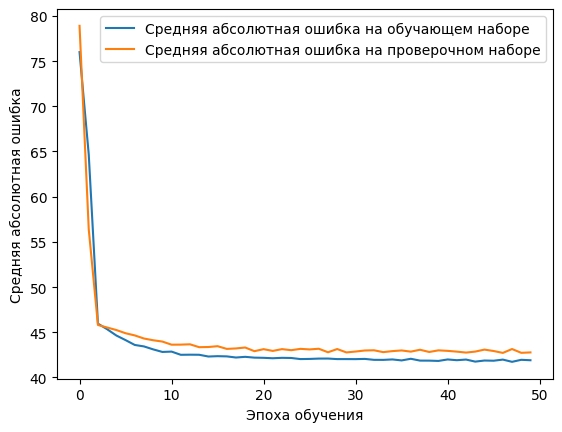

In [ ]:
models_table = {
    "Количество слоев": [],
    "Нейронов в первом слое": [],
    "Дропаут": [],
    "Ошибка на обучающей выборке": [],
    "Ошибка на проверочной выборке": [],
    "Средняя абсолютная ошибка": [],
}  # Инициализация таблицы для результатов

# Списки параметров для перебора
layers_list = [3, 5]
neurons_list = [256, 1024]

for layers in layers_list:  # Перебор количества слоев
    for neurons in neurons_list:  # Перебор количества нейронов в первом слое
        fit_model(models_table, layers, neurons)  # Обучение модели без дропаута
        if layers == 5:
            fit_model(
                models_table, layers, neurons, True
            )  # Обучение модели с дропаутом, если слоев 5


### Сравнительная таблица

In [ ]:
df = pd.DataFrame(models_table) # Создание сравнительной таблицы результатов
display(df)

,Количество слоев,Нейронов в первом слое,Дропаут,Ошибка на обучающей выборке,Ошибка на проверочной выборке,Средняя абсолютная ошибка
0,3,256,Нет,41.843994,43.663612,42.259105
1,3,1024,Нет,41.444489,43.241383,41.781552
2,5,256,Нет,41.878693,43.501961,42.121449
3,5,256,Да,44.728909,42.194340,40.639899
4,5,1024,Нет,41.422424,43.033836,41.535620
5,5,1024,Да,41.905186,42.771439,41.251081
